This notebook follows Rachael Tatman's [Tutorial: Sentiment Analysis in R](https://www.kaggle.com/rtatman/tutorial-sentiment-analysis-in-r).

# Introduction

In [57]:
library(tidyverse)
library(tidytext)
library(glue)
library(stringr)

The dataset can be found at the bottom of the tutorial. It is a .zip file. I made a subfolder to the folder that this notebook lives in and called it 'input' to match the tutorial.

Let's get a list of the files in the input directory so that we know what file names our dataset is stored under.

In [58]:
files <- list.files('./input/')
  # The tutorial uses the path '../input/' but './input/' is correct.

Now consider the first file in the list. We'll tokenize it, i.e. break it into individual words.

In [59]:
# Store the first file's path via glue
fileName <- glue('./input/',files[1],sep="")
  # sep="" tells glue() to stick the arguments together without inserting anything in between.
  # Notice that the first element of a list has position 1 instead of position 0.

# Remove trailing spaces
fileName <- trimws(fileName)

Now we're ready to extract the text from the first file.

In [60]:
# Extract text from the first file
fileText <- glue(read_file(fileName))

The symbol $ is a special character in R signifying the end of a string. We need to make sure to remove them.

In [61]:
# Replace '$' with '' in `fileText`.
fileText <- gsub('\\$','',fileText)

Now we're ready to tokenize the text.

In [62]:
tokens <- tibble(text=fileText) %>% unnest_tokens(word, text)

Firstly, I'm using `tibble()` instead of `data_frame()` because the latter is depreciated in favor of the former.

`%>%` is an infix operator not defined in base R, but used in dplyr (one of the packages loaded by tidyverse) as a pipe, passing the lefthand side to the first argument of the function on the right.

The lefthand side is `tibble(text=fileText)`, which creates a dataframe with header `text`, whose entry is the value of `fileText`.

This dataframe is given to `unnest_tokens()`, which separates the block of text into words. The resulting dataframe `tokens` has header `word`; each entry in the dataframe is a word, presented in the order in which they occur. The punctuation and spaces are stripped.

Now we can take the list (actually a dataframe) of tokens and assign each a sentiment value. There are dictionaries of words where this is already done for us; these dictionaries are called "sentiment lexicons".

The tidytext package comes with some sentiment lexicons. The tutorial uses the "bing" list.

Let's get the sentiment from the first text.

In [63]:
tokens %>%
  inner_join(get_sentiments('bing')) %>%  # Uses only words in bing
  count(sentiment) %>%                    # Tally words by sentiment (+ or -)
  spread(sentiment,n,fill=0) %>%          # Make data wide rather than narrow
  mutate(sentiment=positive-negative)     # Total number of + words minus number - words

Joining, by = "word"



negative,positive,sentiment
<dbl>,<dbl>,<dbl>
59,89,30


There's a problem. Rachel got 117 negative, 240 positive for sentiment of 123...

It's positive her list is merely ordered differently.

Next, we want to do what we did above, but to every file making up our dataset. In addition, we need to make sure we distinguish between the addresses of Bush Sr. vs W.

Let's write a function!

In [64]:
getSentiment <- function(file){
    #' Takes the name of the file and returns the count of + words, count of - words, difference, and normalized difference'
    
    # Get file
    fileName <- glue('./input/',file)
    
    # Remove trailing spaces
    fileName <- trimws(fileName)
    
    # Extract text from the file
    fileText <- glue(read_file(fileName))
    
    # Cleaning: replace '$' with '' in `fileText`.
    fileText <- gsub('\\$','',fileText)
    
    # Tokenize
    tokens <- tibble(text=fileText) %>% unnest_tokens(word, text)
    
    sentiment <- tokens %>%
      inner_join(get_sentiments('bing')) %>%  # Uses only words in bing
      count(sentiment) %>%                    # Tally words by sentiment (+ or -)
      spread(sentiment,n,fill=0) %>%          # Make data wide rather than narrow
      mutate(sentiment=positive-negative) %>% # Total number of + words minus number - words
      mutate(file=file) %>%                   # Add the name of our file
      mutate(year=as.numeric(str_match(file, "\\d{4}"))) %>% # Add the year
      mutate(president=str_match(file,"(.*?)_")[2]) #Add president
    
    return(sentiment)

}

Let's test the function. We should have returned

```
negative	positive	sentiment	file	        year	president
117         240         123         Bush_1989.txt   1989	Bush
```

In [65]:
getSentiment(files[1])

Joining, by = "word"



negative,positive,sentiment,file,year,president
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
59,89,30,Adams_1797.txt,1797,Adams


This confirms that the author's list is ordered in a different way. Yay!

We'll want to apply the function to every file in the dataset. We'll store the results in a dataframe.

In [66]:
sentiments <- tibble()

for (i in files){
    sentiments <- rbind(sentiments,getSentiment(i))
}

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"

Joining, b

In the dataset downloaded from kaggle, I found that `Washington_1790.txt` was blank, producing an error from above. This error was corrected by manually adding the [appropriate SOTU text](http://stateoftheunion.onetwothree.net/texts/17901208.html).

In [67]:
sentiments

negative,positive,sentiment,file,year,president
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
59,89,30,Adams_1797.txt,1797,Adams
47,102,55,Adams_1798.txt,1798,Adams
29,73,44,Adams_1799.txt,1799,Adams
20,83,63,Adams_1800.txt,1800,Adams
139,341,202,Adams_1825.txt,1825,Adams
119,254,135,Adams_1826.txt,1826,Adams
123,236,113,Adams_1827.txt,1827,Adams
128,241,113,Adams_1828.txt,1828,Adams
69,163,94,Arthur_1881.txt,1881,Arthur


Finally, we need to make sure that Bush Sr. and George W. Bush are disambiguated.

First we'll find the rows for Bush Sr. and correct "Bush" to "Bush Sr."

In [68]:
bushSr <- sentiments %>%
  filter(president=="Bush") %>% # Get rows where president is named Bush
  filter(year<2000) %>%         # and the year is before 2000
  mutate(president="Bush Sr.")  # Those are Bush Sr.'s years

Now let's remove those same rows from the dataframe and add in the corrected rows.

In [69]:
sentiments <- anti_join(sentiments,
                        sentiments[sentiments$president=="Bush"&sentiments$year<2000, ])

sentiments <- full_join(sentiments,bushSr)

Joining, by = c("negative", "positive", "sentiment", "file", "year", "president")

Joining, by = c("negative", "positive", "sentiment", "file", "year", "president")



Now we can see the results of all that work!

In [70]:
summary(sentiments)

    negative        positive        sentiment          file          
 Min.   : 20.0   Min.   :  57.0   Min.   : -7.00   Length:228        
 1st Qu.:100.2   1st Qu.: 178.5   1st Qu.: 75.75   Class :character  
 Median :137.5   Median : 280.5   Median :128.00   Mode  :character  
 Mean   :176.6   Mean   : 319.6   Mean   :142.93                     
 3rd Qu.:208.8   3rd Qu.: 383.2   3rd Qu.:183.25                     
 Max.   :820.0   Max.   :1458.0   Max.   :763.00                     
      year       president        
 Min.   :1790   Length:228        
 1st Qu.:1847   Class :character  
 Median :1904   Mode  :character  
 Mean   :1904                     
 3rd Qu.:1961                     
 Max.   :2018                     

Oh no! Rachael has been using an abbeviated dataset this whole time, only SOTU address from 1989 to 2017. Let's cull the sentiments dataframe to match.

In [87]:
sentiments <- anti_join(sentiments,
                       sentiments[sentiments$year<1989|sentiments$year>2017, ])

summary(sentiments)

Joining, by = c("negative", "positive", "sentiment", "file", "year", "president")



    negative        positive       sentiment         file          
 Min.   : 49.0   Min.   :169.0   Min.   : 43.0   Length:29         
 1st Qu.:122.0   1st Qu.:240.0   1st Qu.:102.0   Class :character  
 Median :138.0   Median :293.0   Median :145.0   Mode  :character  
 Mean   :142.5   Mean   :276.3   Mean   :133.8                     
 3rd Qu.:160.0   3rd Qu.:302.0   3rd Qu.:171.0                     
 Max.   :223.0   Max.   :389.0   Max.   :238.0                     
      year       president        
 Min.   :1989   Length:29         
 1st Qu.:1996   Class :character  
 Median :2003   Mode  :character  
 Mean   :2003                     
 3rd Qu.:2010                     
 Max.   :2017                     

Every SOTU address in this dataset has an overall positive sentiment. Since most text, especially formal texts, tend to have a positive skew, this isn't surprising.

Let's get some plots going to see if we notice any patterns.

Below we plot the sentiments over time (x axis is year), with different presidents having different colored points. We'll use an automatic model selection function to model the change.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



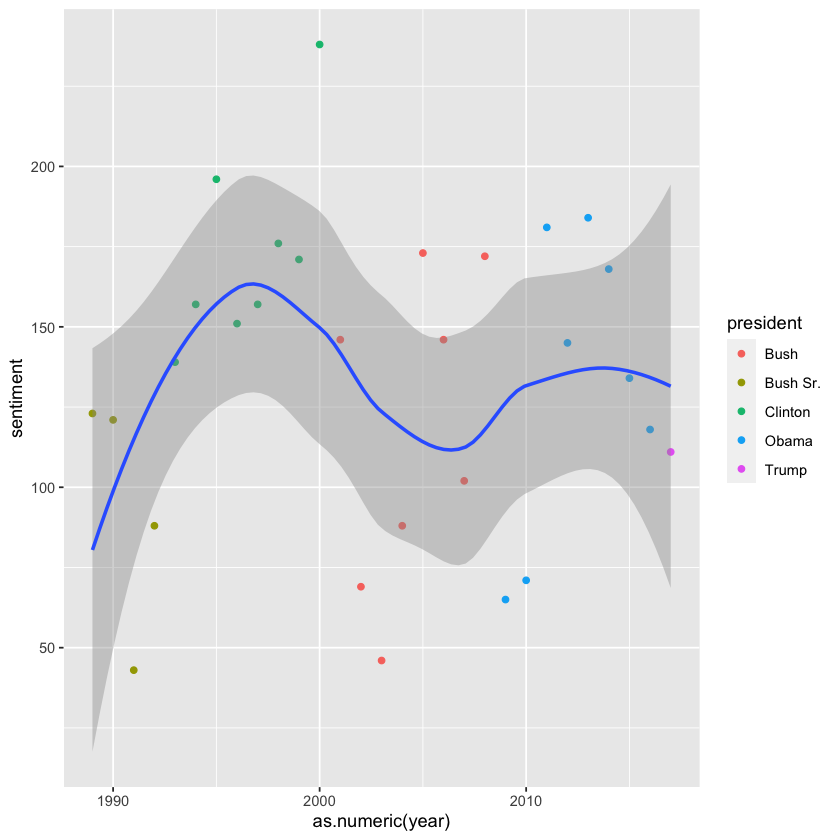

In [88]:
ggplot(sentiments,aes(x=as.numeric(year),y=sentiment)) +
  geom_point(aes(color=president)) +
  geom_smooth(method='auto')

There does not appear to be any strong trends over time, but it appears that democratic presidents (Clinton and Obama) tend to give SOTU addresses with slightly more positive sentiment than those of Republican presidents (Bush Sr., Bush, and Trump).

To see if the pattern holds, we'll look at boxplots for the sentiment for individual presidents.

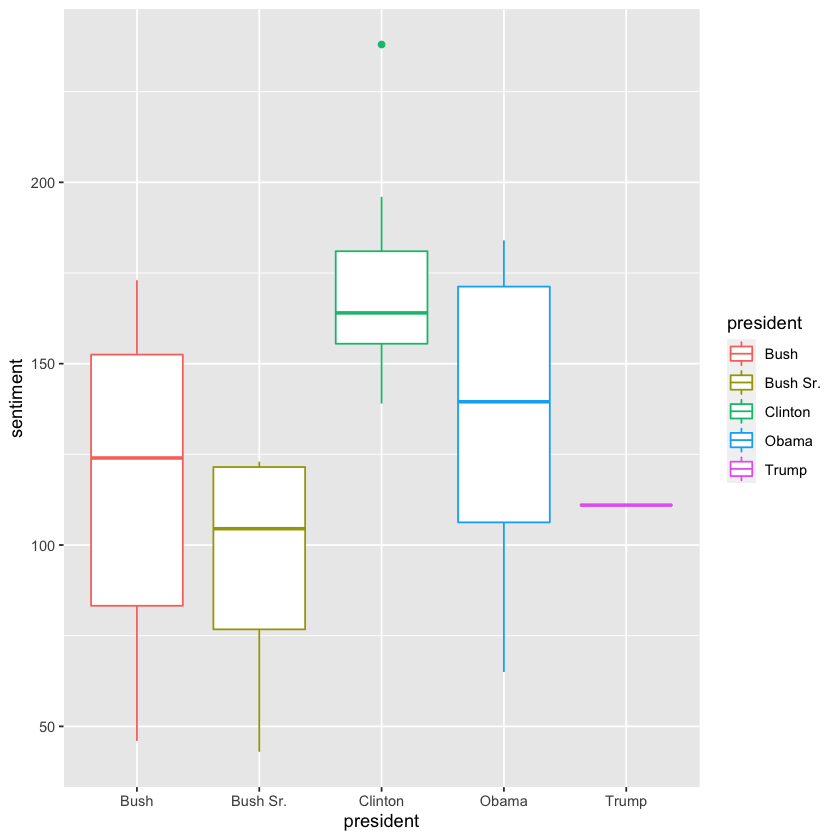

In [89]:
ggplot(sentiments,aes(x=president,y=sentiment,color=president)) +
  geom_boxplot()

The boxplots seem to support the pattern. We can directly compare the two parties to see if there's a reliable difference between them.

Since our dataframe doesn't have labels for each president by party, we'll need to label the presidents manually.

In [96]:
# Labeling democratic presidents
democrats <- sentiments %>%
  filter(president=='Clinton'|president=='Obama') %>%
  mutate(party='D')

# Labeling republican presidents
republicans <- sentiments %>%
  filter(president!='Clinton'&president!='Obama') %>%
  mutate(party='R')

byParty <- full_join(democrats,republicans)

Joining, by = c("negative", "positive", "sentiment", "file", "year", "president", "party")



In the tutorial, Tatman uses the syntax

```
democrats <- sentiments %>%
    filter(president == c("Clinton","Obama")) %>%
    mutate(party = "D")
```

This appears to result in an incomplete `democrats` dataframe, which impedes analysis. The above syntax results in a dataframe containing entries from 1989 to 2017, as desired.

We will now use Student's t-test test to see if the difference between the parties is significant.

In [103]:
t.test(democrats$sentiment,republicans$sentiment)


	Welch Two Sample t-test

data:  democrats$sentiment and republicans$sentiment
t = 2.6948, df = 25.937, p-value = 0.01219
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 10.27737 76.40532
sample estimates:
mean of x mean of y 
 153.1875  109.8462 


Since P<0.05, this data is unlikely to occur if the true difference in mean sentiments of Democratic SOTU addresses vs Republican SOTU addresses is equal to zero; we conclude that the sentiment of the SOTU addresses from 1989 to 2017 tends to be different based on the party affiliation of the president.

Let's visualize the sentiments of the SOTU addresses by party.

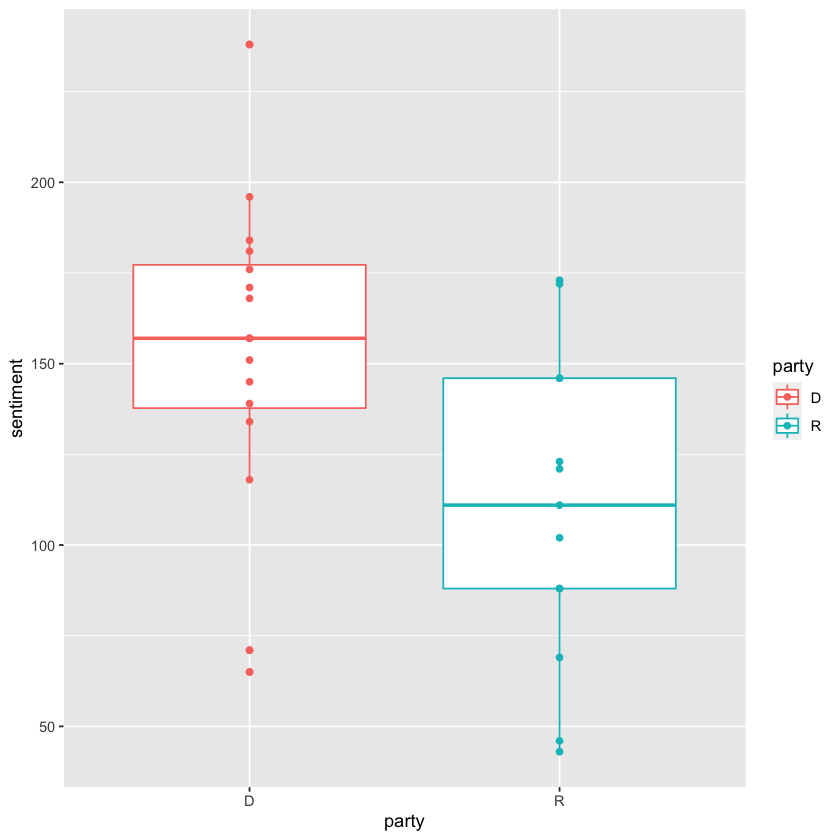

In [99]:
ggplot(byParty,aes(x=party,y=sentiment,color=party)) +
  geom_boxplot() +
  geom_point()

## Future Work

Addressing the following will improve the analysis.

* Correcting for the length of the documents
* Using a list of words specifically designed for analyzing political language, and we only used one semantic lexicon.

Below are exercises from the tutorial.

### Exercise 1: Normalizing for text length

In [104]:
# Rewrite the function GetSentiment so that it also returns the sentiment score
# divided by the number of words in each document.

# hint: you can use the function nrow() on your tokenized data_frame to find 
# the number of tokens in each document

# How does normalizing for text length change the outcome of the analysis?

### Exercise 2: Using a different sentiment lexicon

In [105]:
# The get_sentiments function has a number of different sentiment lexicons
# included in it. Repeat the analysis above with the "afinn" lexicon
# instead of the "bing" lexicon. (You can learnd about the "afinn" lexicon
# here: http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010).
# Note that the "afinn" lexicon uses a scale for annotation. +5 is very 
# positive, while -5 is very negative.

# Does using a different lexicon result in a different outcome for your
# analysis? What does this suggest about the original analysis?

### Exercise 3: Creating your own sentiment lexicon

In [106]:
# Below, I've gotten a list of the 50 most frequent words in this corpus 
# (removing very common words like "and" or "the") that aren't also in the 
# "bing" lexicon. Can you tag these words for their sentiment, either positive,
# negative or neutral, and then use them to augment the "bing" sentiment lexicon?

# hint: you may find it easiest to upload your annotated list as a separate
# dataset and add it to the kernel.

# How does this affect your analysis? Do you think it would have had a different 
# effect if you had annotated 500 words instead? 50,000? Would your new lexicon
# be helpful in analyzing product reviews? Tweets?

In [107]:
# in this code block, we're getting a list of the 100 most frequent words in this
# corpus that 1) aren't stop words and 2) aren't already in the Bing lexicon

# function to get tokens from a file
fileToTokens <- function(file){
    # get the file
    fileName <- glue("../input/", file, sep = "")
    # get rid of any sneaky trailing spaces
    fileName <- trimws(fileName)

    # read in the new file
    fileText <- glue(read_file(fileName))
    # remove any dollar signs (they're special characters in R)
    fileText <- gsub("\\$", "", fileText) 

    # tokenize
    tokens <- data_frame(text = fileText) %>% unnest_tokens(word, text)
}

# empty data_frame to save our data in
allTokens <- NULL

# get the tokens in each file
for(i in files){
    allTokens <- rbind(allTokens, fileToTokens(i))
}

# get words already in the Bing sentiment dictionary
bingWords <- get_sentiments("bing")[,1]

# get the top 100 most frequent words, excluding stop words
# and word already in the "bing" lexicon
top100Words <- allTokens %>% 
    anti_join(stop_words) %>% # remove stop words
    anti_join(bingWords) %>% # remove words in the bing lexicon
    count(word, sort = T) %>% # sort by frequency
    top_n(100) # get the top 100 terms

# Save out the file (it will show up under "output") so you can download it
# and annotate it in a different program (if you like)
write.csv(top100Words, "top100Words.csv")

ERROR: Error: '../input/Adams_1797.txt' does not exist in current working directory ('/Users/victorial/Dropbox/2020 Spring/Project/Tatman tidytext tutorial').


### Exercise 4: Analyzing a new dataset

Now that you've got the skills to do sentiment analyis, it's time to apply them to a new dataset. You can find a list of text corpora already on Kaggle [here](https://www.kaggle.com/datasets?sortBy=updated&group=featured&search=corpus), but I've also selected a couple that I think would lend themselves well to sentiment analysis. I've also included some links to other sentiment lexicons you can find on Kaggle. Many are even for low-resource languages!